# Triple Generative Adversarial Networks with MedNIST Dataset



## Setup environment

In [1]:
!pip install monai
!pip install monai-generative
!pip install lpips

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

## Setup imports

In [2]:
import os
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
from monai import transforms
from monai.apps import MedNISTDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader,Dataset
from monai.utils import first, set_determinism
from torch.nn import L1Loss
from tqdm import tqdm

from generative.losses import PatchAdversarialLoss, PerceptualLoss
from generative.networks.nets import VQVAE, PatchDiscriminator

print_config()

MONAI version: 1.3.0
Numpy version: 1.25.2
Pytorch version: 2.2.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.19.3
scipy version: 1.11.4
Pillow version: 9.4.0
Tensorboard version: 2.15.2
gdown version: 4.7.3
TorchVision version: 0.17.1+cu121
tqdm version: 4.66.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.38.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
   

## Setup data directory

You can specify a directory with the MONAI_DATA_DIRECTORY environment variable.

This allows you to save results and reuse downloads.

If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpu9l7dbim


## Set deterministic training for reproducibility

In [4]:
set_determinism(42)

## Setup MedNIST Dataset and training and validation dataloaders


In [5]:
train_data = MedNISTDataset(root_dir=root_dir, section="training", download=True, seed=0)
train_datalist = [{"image": item["image"]} for item in train_data.data if item["class_name"] == "HeadCT"]
image_size = 64
train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
        transforms.RandAffined(
            keys=["image"],
            rotate_range=[(-np.pi / 36, np.pi / 36), (-np.pi / 36, np.pi / 36)],
            translate_range=[(-1, 1), (-1, 1)],
            scale_range=[(-0.05, 0.05), (-0.05, 0.05)],
            spatial_size=[image_size, image_size],
            padding_mode="zeros",
            prob=0.5,
        ),
    ]
)
train_ds = Dataset(data=train_datalist, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=4, persistent_workers=True)

MedNIST.tar.gz: 59.0MB [00:00, 68.8MB/s]                            

2024-03-21 19:11:37,602 - INFO - Downloaded: /tmp/tmpu9l7dbim/MedNIST.tar.gz


2024-03-21 19:11:37,722 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-03-21 19:11:37,724 - INFO - Writing into directory: /tmp/tmpu9l7dbim.


Loading dataset: 100%|██████████| 47164/47164 [00:35<00:00, 1314.49it/s]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Visualization of the training images

batch shape: torch.Size([128, 1, 64, 64])


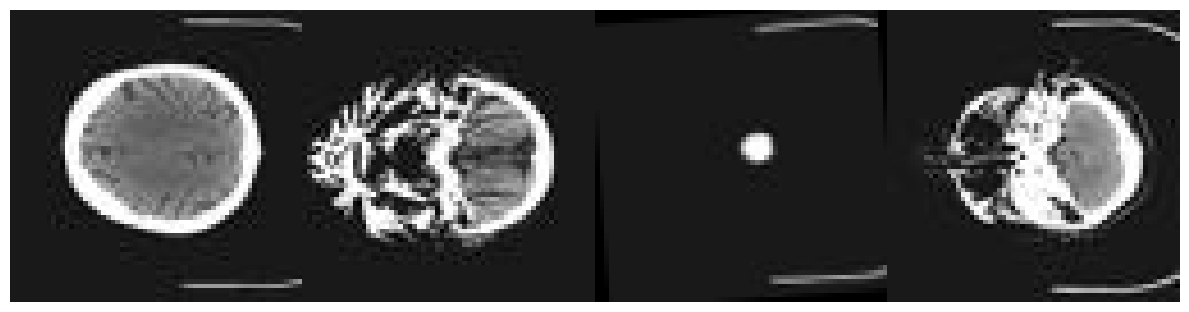

In [6]:
check_data = first(train_loader)
print(f"batch shape: {check_data['image'].shape}")
image_visualization = torch.cat(
    [check_data["image"][0, 0], check_data["image"][1, 0], check_data["image"][2, 0], check_data["image"][3, 0]], dim=1
)
plt.figure("training images", (12, 6))
plt.imshow(image_visualization, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

In [7]:
val_data = MedNISTDataset(root_dir=root_dir, section="validation", download=True, seed=0)
val_datalist = [{"image": item["image"]} for item in val_data.data if item["class_name"] == "HeadCT"]
val_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.ScaleIntensityRanged(keys=["image"], a_min=0.0, a_max=255.0, b_min=0.0, b_max=1.0, clip=True),
    ]
)
val_ds = Dataset(data=val_datalist, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=128, shuffle=True, num_workers=4, persistent_workers=True)

2024-03-21 19:12:40,023 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-03-21 19:12:40,024 - INFO - File exists: /tmp/tmpu9l7dbim/MedNIST.tar.gz, skipped downloading.
2024-03-21 19:12:40,027 - INFO - Non-empty folder exists in /tmp/tmpu9l7dbim/MedNIST, skipped extracting.


Loading dataset: 100%|██████████| 5895/5895 [00:04<00:00, 1266.46it/s]


### Define network, scheduler and optimizer
At this step, we instantiate the MONAI components to create a VQVAE and a Discriminator model. We are using the
Discriminator to train the Autoencoder with a Generative Adversarial loss, where the VQVAE works as a Generator.
The VQVAE is trained to minimize the reconstruction error, a perceptual loss using AlexNet as the embedding model
and an adversarial loss versus the performance of the Discriminator.

In [8]:
device = torch.device("cuda")

model = VQVAE(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(128, 512),
    num_res_channels=512,
    num_res_layers=2,
    downsample_parameters=((2, 4, 1, 1), (2, 4, 1, 1)),
    upsample_parameters=((2, 4, 1, 1, 0), (2, 4, 1, 1, 0)),
    num_embeddings=256,
    embedding_dim=32,
)
model.to(device)

discriminator = PatchDiscriminator(spatial_dims=2, in_channels=1, num_layers_d=3, num_channels=64)
discriminator.to(device)

perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
perceptual_loss.to(device)

optimizer_g = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=5e-4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:04<00:00, 57.5MB/s]


In [11]:
import pickle
with open("classifer.pkl","rb") as f:
  classifier=pickle.load(f)
classifier.to(device)
classifier_criterion = torch.nn.CrossEntropyLoss()

In [12]:
l1_loss = L1Loss()
adv_loss = PatchAdversarialLoss(criterion="least_squares")
adv_weight = 0.01
perceptual_weight = 0.001
classifer_loss_weight=0.001

### Model training

In [13]:
n_epochs = 100
val_interval = 10
epoch_recon_loss_list = []
epoch_gen_loss_list = []
epoch_disc_loss_list = []
val_recon_epoch_loss_list = []
intermediary_images = []
epoch_classifier_loss_list=[]
n_example_images = 4

total_start = time.time()
for epoch in range(n_epochs):
    model.train()
    discriminator.train()
    classifier.eval()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    classifier_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=200)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(device)
        optimizer_g.zero_grad(set_to_none=True)


        reconstruction, quantization_loss = model(images=images)
        # Classifier part

        reconstructed_class_logits = classifier(reconstruction.contiguous().float())
        reconstructed_class_labels = torch.full_like(reconstructed_class_logits[:, -1],fill_value=5,dtype=torch.long )  #"HeadCT" is the last class
        loss_c = classifier_criterion(reconstructed_class_logits, reconstructed_class_labels)


        # Generator part
        logits_fake = discriminator(reconstruction.contiguous().float())[-1]

        recons_loss = l1_loss(reconstruction.float(), images.float())
        p_loss = perceptual_loss(reconstruction.float(), images.float())
        generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
        loss_g = recons_loss + quantization_loss + perceptual_weight * p_loss + adv_weight * generator_loss + loss_c * 0.01

        loss_g.backward(retain_graph=True)
        optimizer_g.step()


        # Discriminator part
        optimizer_d.zero_grad(set_to_none=True)

        logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
        loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
        logits_real = discriminator(images.contiguous().detach())[-1]
        loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
        discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

        loss_d = adv_weight * discriminator_loss

        loss_d.backward(retain_graph=True)
        optimizer_d.step()


        epoch_loss += recons_loss.item()
        gen_epoch_loss += generator_loss.item()
        disc_epoch_loss += discriminator_loss.item()
        classifier_epoch_loss += loss_c.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
                "classifier_loss": classifier_epoch_loss / (step + 1),

            }
        )
    epoch_recon_loss_list.append(epoch_loss / (step + 1))
    epoch_gen_loss_list.append(gen_epoch_loss / (step + 1))
    epoch_disc_loss_list.append(disc_epoch_loss / (step + 1))
    epoch_classifier_loss_list.append(classifier_epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_step, batch in enumerate(val_loader, start=1):
                images = batch["image"].to(device)

                reconstruction, quantization_loss = model(images=images)

                # get the first sammple from the first validation batch for visualization
                # purposes
                if val_step == 1:
                    intermediary_images.append(reconstruction[:n_example_images, 0])


                recons_loss = l1_loss(reconstruction.float(), images.float())

                val_loss += recons_loss.item()

        val_loss /= val_step
        val_recon_epoch_loss_list.append(val_loss)

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

Epoch 99: 100%|████████████████████████████████████████████████████████████████████████████| 63/63 [00:41<00:00,  1.53it/s, recons_loss=0.0223, gen_loss=0.418, disc_loss=0.218, classifier_loss=0.0149]


train completed, total time: 4155.521003246307.


### Learning curves

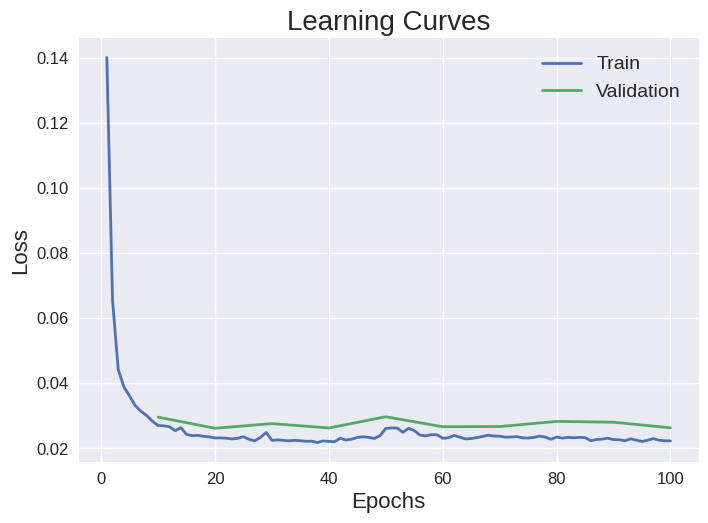

In [14]:
plt.style.use("seaborn-v0_8")
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_recon_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
    val_recon_epoch_loss_list,
    color="C1",
    linewidth=2.0,
    label="Validation",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

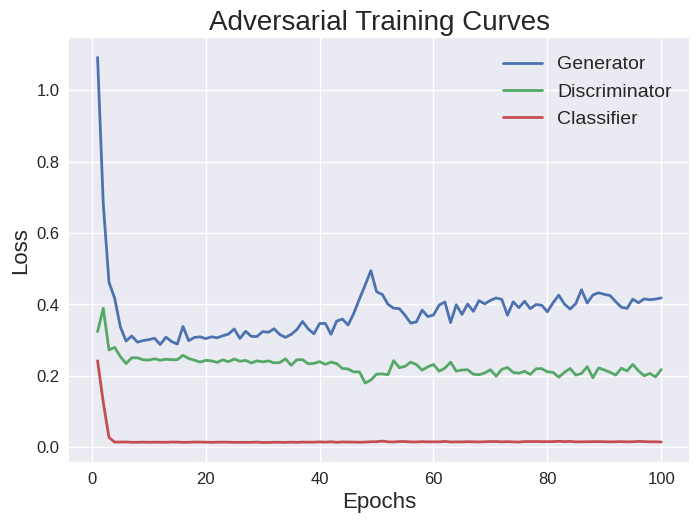

In [16]:
n_epochs=100
plt.title("Adversarial Training Curves", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_gen_loss_list, color="C0", linewidth=2.0, label="Generator")
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_disc_loss_list, color="C1", linewidth=2.0, label="Discriminator")
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_classifier_loss_list, color="C2", linewidth=2.0, label="Classifier")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

In [19]:
with open("generator.pkl","wb") as f:
  pickle.dump(model,f)

### Checking reconstructions

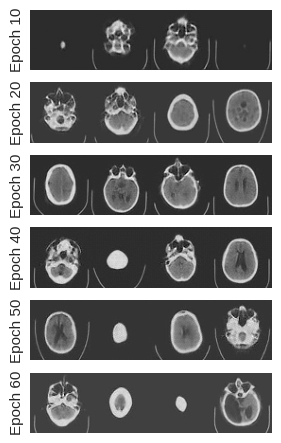

In [29]:
# Plot first 4 evaluations
val_samples = np.linspace(val_interval, n_epochs, int(n_epochs / val_interval))
fig, ax = plt.subplots(nrows=6, ncols=1, sharey=True)
for image_n in range(6):
    reconstructions = torch.reshape(intermediary_images[image_n], (64 * n_example_images, 64)).T
    ax[image_n].imshow(reconstructions.cpu(), cmap="gray")
    ax[image_n].set_xticks([])
    ax[image_n].set_yticks([])
    ax[image_n].set_ylabel(f"Epoch {val_samples[image_n]:.0f}")

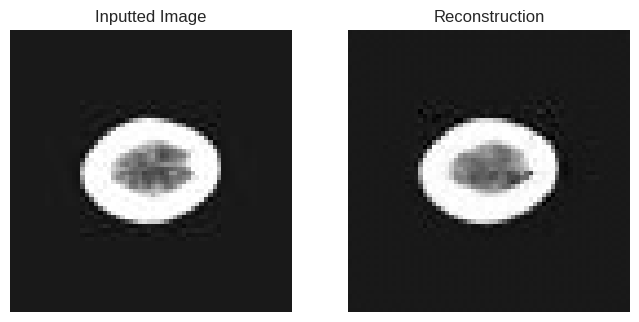

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(images[0, 0].detach().cpu(), vmin=0, vmax=1, cmap="gray")
ax[0].axis("off")
ax[0].title.set_text("Inputted Image")
ax[1].imshow(reconstruction[0, 0].detach().cpu(), vmin=0, vmax=1, cmap="gray")
ax[1].axis("off")
ax[1].title.set_text("Reconstruction")
plt.show()

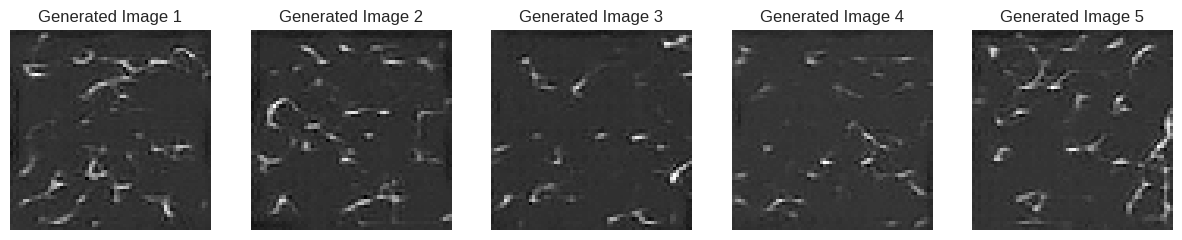

In [33]:
import matplotlib.pyplot as plt

image_shape = (1,1, 64, 64)
num_of_samples = 5

with torch.no_grad():
    fig, axes = plt.subplots(1, num_of_samples, figsize=(15, 3))

    for n in range(num_of_samples):
        # Pass the random noise through the model
        noise = torch.randn(image_shape).to(device)
        generated_images, loss = model(noise)
        # Plot the generated image
        axes[n].imshow(generated_images.squeeze().cpu().numpy(), cmap='gray')
        axes[n].axis('off')
        axes[n].set_title(f'Generated Image {n+1}')

plt.show()

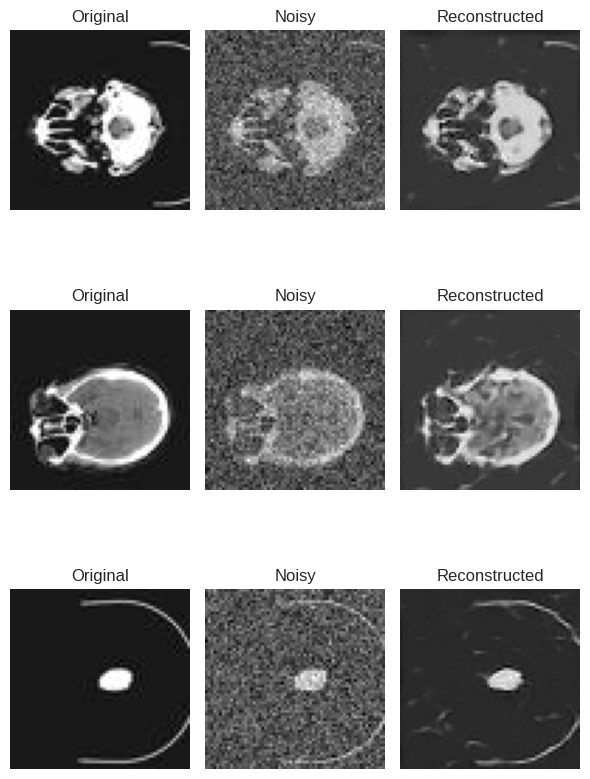

In [41]:
for batch in val_loader:
    images = batch["image"].to(device)
    break

# Add noise to the image
noise_std = 0.2
noisy_images = images + noise_std * torch.randn_like(images)

with torch.no_grad():
    reconstructed_images, _ = model(noisy_images)

num_samples = min(images.shape[0], 3)
fig, axes = plt.subplots(num_samples, 3, figsize=(6, num_samples * 3))

for i in range(num_samples):
    axes[i, 0].imshow(images[i, 0].cpu(), cmap='gray')
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(noisy_images[i, 0].cpu(), cmap='gray')
    axes[i, 1].set_title('Noisy')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(reconstructed_images[i, 0].cpu(), cmap='gray')
    axes[i, 2].set_title('Reconstructed')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()


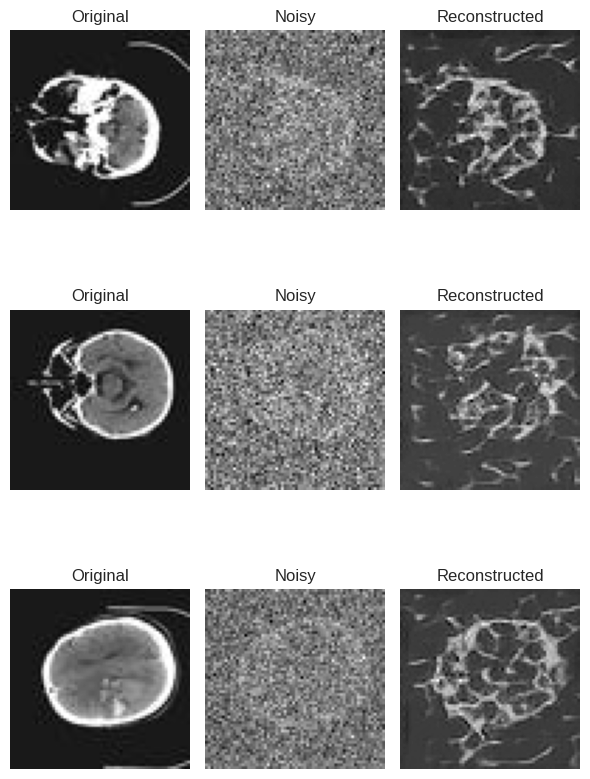

In [42]:
for batch in val_loader:
    images = batch["image"].to(device)
    break

# Add noise to the image
noise_std = 0.9
noisy_images = images + noise_std * torch.randn_like(images)

with torch.no_grad():
    reconstructed_images, _ = model(noisy_images)

num_samples = min(images.shape[0], 3)
fig, axes = plt.subplots(num_samples, 3, figsize=(6, num_samples * 3))

for i in range(num_samples):
    axes[i, 0].imshow(images[i, 0].cpu(), cmap='gray')
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(noisy_images[i, 0].cpu(), cmap='gray')
    axes[i, 1].set_title('Noisy')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(reconstructed_images[i, 0].cpu(), cmap='gray')
    axes[i, 2].set_title('Reconstructed')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()
